In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)

In [2]:
# Read the data and dump statistics

orig_obsdata = pd.read_csv('../data_files/good_qual_full.csv', parse_dates=['Date']); ms=20; alpha=0.7
# orig_obsdata = pd.read_csv('../data_files/good_qual_1deg.csv', parse_dates=['Date']); ms=4; alpha=0.1
print('** SUMMARY STATISTICS **')
print('Unique observation names:', len(orig_obsdata.groupby('Observation')))
print('Total slices:', len(orig_obsdata))
print('Starting date:', orig_obsdata['Date'].min())
print('Ending date:', orig_obsdata['Date'].max())
print('Time span:', orig_obsdata['Date'].max()-orig_obsdata['Date'].min())

good_i = np.abs(orig_obsdata['Incidence']-90) > 1.5
obsdata = orig_obsdata[good_i].copy()
print('Removed OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
print('Final unique observation names:', len(obsdata))

** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39
Removed OBSIDs: {'ISS_110RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME'}
Final unique observation names: 145


# Optimize Tau for Low-Phase Observations

In [3]:
# Find "small" (<6) e or i

obsdata['Mu'] = np.abs(np.cos(np.radians(obsdata['Mean Emission'])))
obsdata['Mu0'] = np.abs(np.cos(np.radians(obsdata['Incidence'])))
low_phase_mask = obsdata['Mean Phase'] <= 60
low_phase_mask &= obsdata['Observation'] != 'ISS_091RF_FMOVIE003_PRIME'
low_phase_mask &= obsdata['Observation'] != 'ISS_107RF_FMOVIE002_PRIME'
low_phase_mask &= obsdata['Observation'] != 'ISS_189RF_FMOVIE001_PRIME'

low_phase_obsdata = obsdata[low_phase_mask]
lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
low_i_mask = np.abs(obsdata['Incidence']-90) < 6
low_ei_mask = low_e_mask | low_i_mask

Tau 0.000 - Slope:  0.22168
Tau 0.001 - Slope:  0.21401
Tau 0.002 - Slope:  0.20626
Tau 0.003 - Slope:  0.19845
Tau 0.004 - Slope:  0.19056
Tau 0.005 - Slope:  0.18261
Tau 0.006 - Slope:  0.17459
Tau 0.007 - Slope:  0.16649
Tau 0.008 - Slope:  0.15833
Tau 0.009 - Slope:  0.15009
Tau 0.010 - Slope:  0.14178
Tau 0.011 - Slope:  0.13340
Tau 0.012 - Slope:  0.12494
Tau 0.013 - Slope:  0.11642
Tau 0.014 - Slope:  0.10782
Tau 0.015 - Slope:  0.09915
Tau 0.016 - Slope:  0.09040
Tau 0.017 - Slope:  0.08158
Tau 0.018 - Slope:  0.07269
Tau 0.019 - Slope:  0.06372
Tau 0.020 - Slope:  0.05467
Tau 0.021 - Slope:  0.04555
Tau 0.022 - Slope:  0.03636
Tau 0.023 - Slope:  0.02709
Tau 0.024 - Slope:  0.01774
Tau 0.025 - Slope:  0.00832
Tau 0.026 - Slope: -0.00118
Tau 0.027 - Slope: -0.01076
Tau 0.028 - Slope: -0.02042
Tau 0.029 - Slope: -0.03015
Tau 0.030 - Slope: -0.03997
Tau 0.031 - Slope: -0.04986
Tau 0.032 - Slope: -0.05983
Tau 0.033 - Slope: -0.06988
Tau 0.034 - Slope: -0.08000
Tau 0.035 - Slope: -

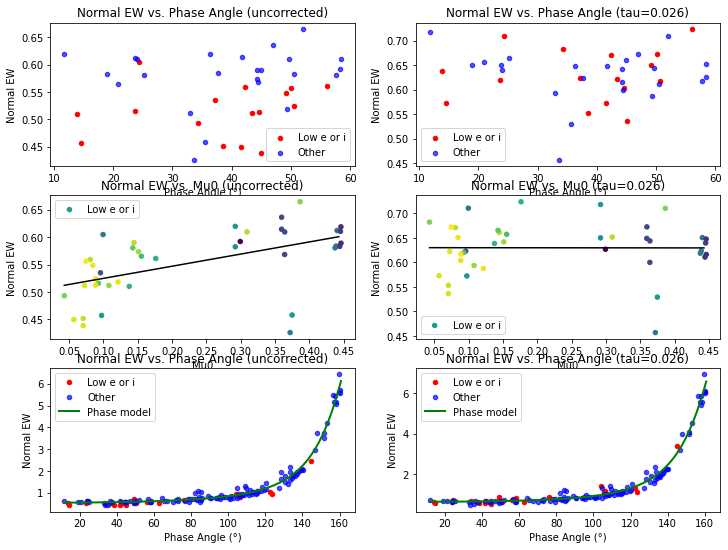

In [9]:
# Find the optimal tau to minimize scatter

best_tau = None
best_slope = 1e38
for tau in np.arange(0.000, 0.041, 0.001):
    corrected_ew = compute_corrected_ew(low_phase_obsdata['Normal EW'], 
                                        low_phase_obsdata['Mean Emission'], 
                                        low_phase_obsdata['Incidence'], 
                                        tau=tau)
    coeff = np.polyfit(low_phase_obsdata['Mu0'], corrected_ew, 1)
    if abs(coeff[0]) < best_slope:
        best_slope = abs(coeff[0])
        best_tau = tau
    print(f'Tau {tau:.3f} - Slope: {coeff[0]:8.5f}')
print()
print(f'** Best Tau: {best_tau:.3f}')

print()
print('Uncorrected Low Phase:')
uc_mean_low = np.mean(low_phase_obsdata['Normal EW'][lp_low_ei_mask])
uc_mean_notlow = np.mean(low_phase_obsdata['Normal EW'][~lp_low_ei_mask])
print(f'Mean Normal EW Low E/I: {uc_mean_low:.5f}')
print(f'Mean Normal EW Other:   {uc_mean_notlow:.5f}')
print(f'Other/Low: {uc_mean_notlow/uc_mean_low:.5f}')
print()

lp_corrected_ew = compute_corrected_ew(low_phase_obsdata['Normal EW'], 
                                       low_phase_obsdata['Mean Emission'], 
                                       low_phase_obsdata['Incidence'], 
                                       tau=best_tau)
mean_low = np.mean(lp_corrected_ew[lp_low_ei_mask])
mean_notlow = np.mean(lp_corrected_ew[~lp_low_ei_mask])
print(f'Corrected (tau={best_tau:.3f}) Low Phase:')
print(f'Mean Normal EW Low E/I: {mean_low:.5f}')
print(f'Mean Normal EW Other:   {mean_notlow:.5f}')
print(f'Other/Low: {mean_notlow/mean_low:.5f}')

print()
print('Overall change due to Tau:')
print(f'Mean Normal EW Low E/I: {mean_low/uc_mean_low:.5f}')
print(f'Mean Normal EW Other:   {mean_notlow/uc_mean_notlow:.5f}')

# Find H-G phase curve for full dataset
corrected_ew = compute_corrected_ew(obsdata['Normal EW'], 
                                    obsdata['Mean Emission'], 
                                    obsdata['Incidence'], 
                                    tau=best_tau)

uc_hg_params, uc_hg_used_data, uc_hg_std = fit_hg_phase_function(2, None, obsdata, 
                                                                 verbose=False)
print()
print('Uncorrected H-G params:')
print_hg_params(uc_hg_params, indent=2)
print(f'  Standard deviation: {uc_hg_std:.5f}')

hg_params, hg_used_data, hg_std = fit_hg_phase_function(2, None, obsdata, 
                                                        tau=best_tau,
                                                        verbose=False)
print()
print(f'Corrected (tau={best_tau:.3f}) params:')
print_hg_params(hg_params, indent=2)
print(f'  Standard deviation: {hg_std:.5f}')

# Plot results
plt.figure(figsize=(12,9))
plt.subplot(3, 2, 1)
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], 
            low_phase_obsdata['Normal EW'][lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], 
            low_phase_obsdata['Normal EW'][~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(3, 2, 2)
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], 
            lp_corrected_ew[lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], 
            lp_corrected_ew[~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')

plt.subplot(3, 2, 3)
plt.scatter(low_phase_obsdata['Mu0'], 
            low_phase_obsdata['Normal EW'], 
            s=ms, label='Low e or i', c=low_phase_obsdata['Mean Emission'])
coeff = np.polyfit(low_phase_obsdata['Mu0'], low_phase_obsdata['Normal EW'], 1)
print(coeff)
mu0range = np.arange(low_phase_obsdata['Mu0'].min(), low_phase_obsdata['Mu0'].max(), 0.01)
fit = np.polyval(coeff, mu0range)
plt.plot(mu0range, fit, '-', c='k')
plt.legend()
plt.xlabel('Mu0')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Mu0 (uncorrected)')

plt.subplot(3, 2, 4)
plt.scatter(low_phase_obsdata['Mu0'], 
            lp_corrected_ew, 
            s=ms, label='Low e or i', c=low_phase_obsdata['Mean Emission'])
coeff = np.polyfit(low_phase_obsdata['Mu0'], lp_corrected_ew, 1)
mu0range = np.arange(low_phase_obsdata['Mu0'].min(), low_phase_obsdata['Mu0'].max(), 0.01)
fit = np.polyval(coeff, mu0range)
print(coeff)
plt.plot(mu0range, fit, '-', c='k')
plt.legend()
plt.xlabel('Mu0')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Mu0 (tau={best_tau:.3f})')

plt.subplot(3, 2, 5)
plt.scatter(obsdata['Mean Phase'][low_ei_mask], 
            obsdata['Normal EW'][low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(obsdata['Mean Phase'][~low_ei_mask], 
            obsdata['Normal EW'][~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
uc_hg_phase_model = hg_func(uc_hg_params, np.radians(xrange))
plt.plot(xrange, uc_hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(3, 2, 6)
plt.scatter(obsdata['Mean Phase'][low_ei_mask], 
            corrected_ew[low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(obsdata['Mean Phase'][~low_ei_mask], 
            corrected_ew[~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
hg_phase_model = hg_func(hg_params, np.radians(xrange))
plt.plot(xrange, hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')
plt.show()

In [5]:
low_phase_obsdata[corrected_ew > 0.70]

/tmp/ipykernel_935926/1399634453.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  low_phase_obsdata[corrected_ew > 0.70]


,Observation,Slice#,Num Data,Date,Min Long,Max Long,Min Res,Max Res,Mean Res,Min Phase,...,Max Emission,Mean Emission,Incidence,% Coverage,EW,EW Std,Normal EW,Normal EW Std,Mu,Mu0
20,ISS_051RI_LPMRDFMOV001_PRIME,0,15876,2007-10-18 21:11:11,0.0,359.98,17.492,82.404,29.780,54.899,...,94.141,94.081,79.850,88.200000,7.89085,1.36291,0.56121,0.09504,0.071167,0.176226
29,ISS_079RF_FRINGMRLF002_PRIME,0,11291,2008-08-06 01:42:23,79.6,305.40,8.635,13.675,10.894,21.175,...,72.510,68.244,84.295,62.727778,1.63948,0.44302,0.60490,0.17208,0.370655,0.099407
69,ISS_177RF_FRSTRCHAN001_PRIME_2,0,5716,2012-12-25 09:20:29,0.0,359.98,6.336,16.680,7.149,9.765,...,84.342,82.991,73.015,31.755556,5.14214,1.33921,0.61987,0.15544,0.122025,0.292121
105,ISS_207RF_FMOVIE001_PRIME,0,15526,2014-08-16 11:01:17,0.0,359.98,7.982,12.837,9.711,46.626,...,117.211,113.272,67.262,86.255556,1.68951,0.57950,0.66474,0.22777,0.395097,0.386518


In [6]:
obsdata['Observation'] == 'ISS_091RF_FMOVIE003_PRIME'

0      False
1      False
2      False
3      False
4      False
       ...  
146    False
147    False
148    False
149    False
150    False
Name: Observation, Length: 145, dtype: bool